In [55]:
 import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from pathlib import Path
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from lockdowndates.core import LockdownDates
from sklearn.linear_model import LinearRegression, Ridge

from catboost import CatBoostRegressor
from jours_feries_france import JoursFeries
from vacances_scolaires_france import SchoolHolidayDates
from datetime import timedelta, date

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [29]:
X, y = utils.get_train_data()
X_final_test = pd.read_parquet(Path("data") / "final_test.parquet")

In [50]:
preproc = utils.prepro(X)
preproc.columns

Index(['counter_id', 'latitude', 'longitude', 'is_couvre_feu', 'temp',
       'precip', 'windspeed', 'visibility', 'icon_encoded', 'is_lockdown',
       'is_ferie', 'is_vacances', 'year', 'month', 'day', 'weekday', 'hour',
       'is_weekend'],
      dtype='object')

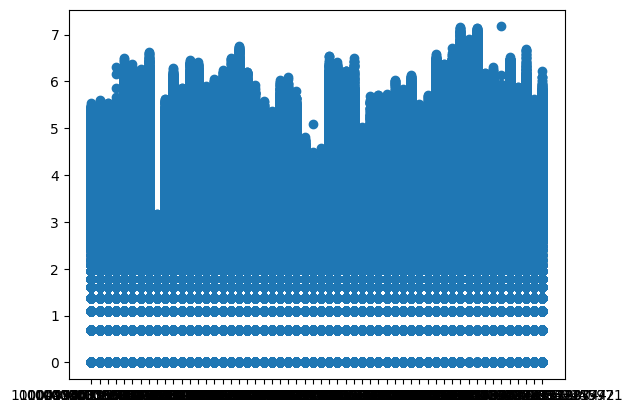

In [53]:
plt.scatter(preproc['counter_id'],y)

In [61]:
import numpy as np
from scipy import stats

def remove_outliers(X, y, z_score_threshold=2):
    """
    Remove outliers from the dataset based on the z-score of the target variable.

    Parameters:
    X (np.array): 2D array with the input features.
    y (np.array): 1D array with the target variable.
    z_score_threshold (float): The threshold of the z-score to identify outliers.

    Returns:
    np.array: Cleaned 2D array with the input features.
    np.array: Cleaned 1D array with the target variable.
    """
# Calculate z-scores of the target variable
    z_scores = np.abs(stats.zscore(y))
    
    # Identify indices of non-outliers
    non_outliers = (z_scores < z_score_threshold)
    
    # Remove outliers from the input features and the target variable
    X_clean = X[non_outliers]
    y_clean = y[non_outliers]
    
    return X_clean, y_clean

# Assuming X is a DataFrame and y is a Series
X_clean, y_clean = remove_outliers(X, y, z_score_threshold=2)
# Now you can use X_clean and y_clean for further modeling.

## Dense

In [62]:
num_features = ['temp', 'precip', 'windspeed', 'visibility']
cat_features = ['counter_id']
time_features = ['hour','month','weekday','day']

col_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(sparse=False), cat_features),
       # ('time', FunctionTransformer(utils.encode_cyclical_features), time_features)
    ],
    remainder='passthrough'
)


X_final_test = pd.read_parquet(Path("data") / "final_test.parquet")

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [63]:
cat = CatBoostRegressor(
    depth=10,
    iterations=1000,
    rsm=0.25,
    sampling_frequency="PerTree",
    subsample=0.7,
    verbose=0,
)

pipe = Pipeline([
    ('prepro',FunctionTransformer(utils.prepro)),
    ('col', col_transformer),
    ('model', cat)
])


pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.3599981562061909


In [64]:
catboost_predictions_train = pipe.predict(X_train)
catboost_predictions_test = pipe.predict(X_test)



In [65]:
pipe2 = Pipeline([
    ('prepro',FunctionTransformer(utils.prepro)),
    ('col', col_transformer),
])
X_train_prepro = pipe2.fit_transform(X_train)
X_test_prepro = pipe2.fit_transform(X_test)


X_train_with_predictions = np.hstack((X_train_prepro, catboost_predictions_train.reshape(-1, 1)))
X_test_with_predictions = np.hstack((X_test_prepro, catboost_predictions_test.reshape(-1, 1)))


In [66]:
linear = Ridge(alpha=0.9)
linear.fit(X_train_with_predictions, y_train)

y_pred = linear.predict(X_test_with_predictions)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.3595244238148336


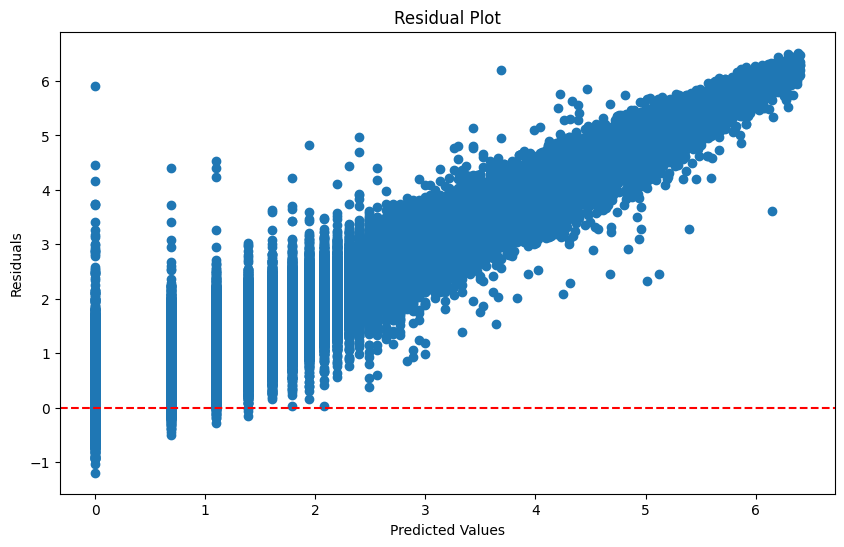

In [71]:
residuals = y_test - y_pred

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [39]:
submission = pipe.predict(X_final_test)
pd.DataFrame(submission, columns=["log_bike_count"]).rename_axis('Id').to_csv('submission35_101223.csv')

In [67]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 17.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 13.9 MB/s eta 0:00:0000:0100:01
  Using cached numba-0.58.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 21.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 17.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 22.2 MB/s eta 0:00:00a 0:00:01
   

In [68]:
from pycaret.regression import *


df = X.copy()
df['target'] = y

# Setup the PyCaret environment
reg_experiment = setup(df, target='target', session_id=123, silent=True, verbose=False)

# Compare models to find the best one
best_model = compare_models()

# Print the best model
print(best_model)

# You can also create a model directly, for example:
# created_model = create_model('rf')  # For a Random Forest

# Tune the best model for better performance
tuned_best_model = tune_model(best_model)

# Finalize the model (trains on the entire dataset including the holdout set)
final_model = finalize_model(tuned_best_model)


ValueError: sklearn.metrics._dist_metrics.DistanceMetric size changed, may indicate binary incompatibility. Expected 472 from C header, got 16 from PyObject